In [ ]:
import os
project_path = '/user/HS402/zs00774/Downloads'  # Update with your project path
os.chdir(project_path)

In [2]:
import zipfile
import os
# Unzip dataset
zip_path = '/content/drive/MyDrive/AML/HMDB_simp.zip'
extract_path = '/content/drive/MyDrive/AML'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to {extract_path}")

Dataset extracted to /content/drive/MyDrive/AML


In [3]:
os.chdir('/content/drive/MyDrive/AML')

In [8]:
!pip install -r requirements.txt

In [9]:
import torch
import numpy as np
import json
from transformers import Trainer, TrainingArguments,EarlyStoppingCallback
from transformers.trainer_utils import IntervalStrategy
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress FutureWarnings
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import GradScaler, autocast  # For mixed precision training
import logging
import sys
import argparse
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

from transformers import AutoImageProcessor, AutoModelForVideoClassification
import os
from transformers import TimesformerForVideoClassification

In [11]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

class MultiClipHMDBDataset(Dataset):
    def __init__(self, split_dir, clip_size=8, frame_rate=32, transform=None):
        """
        Dataset that loads from pre-split folder structure

        Args:
            split_dir (str): Path to split directory (train, val, or test folder)
            clip_size (int): Number of frames per clip
            frame_rate (int): Sampling rate (every Nth frame)
            transform: Torchvision transforms
        """
        self.split_dir = split_dir
        self.clip_size = clip_size
        self.frame_rate = frame_rate
        self.transform = transform

        # Get all class folders in the split directory
        self.classes = sorted([d for d in os.listdir(split_dir)
                              if os.path.isdir(os.path.join(split_dir, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}


        self.data = self._load_data()

    def _interpolate_frames(self, frames_list):
        """Add interpolated frames between consecutive frames"""
        if len(frames_list) < 2:
            return frames_list

        new_frames = []
        for i in range(len(frames_list) - 1):
            new_frames.append(frames_list[i])
            # Add interpolated frame between current and next
            interp_name = f"interp_{frames_list[i]}_{frames_list[i+1]}"
            new_frames.append(interp_name)
        new_frames.append(frames_list[-1])  # Add last frame
        return new_frames

    def _reverse_frames(self, frames_list):
        """Add temporally reversed frames"""

        reversed_frames = frames_list[::-1][1:]
        return frames_list + reversed_frames

    def _brightness_augment_frames(self, frames_list):
        """Add brightness-varied versions of frames"""
        brightness_levels = [0.6, 0.8, 1.2, 1.4]
        new_frames = frames_list.copy()

        for brightness in brightness_levels:
            for frame in frames_list:
                bright_frame = f"bright_{brightness}_{frame}"
                new_frames.append(bright_frame)

        return new_frames



    def _augment_frames_sequence(self, frames_list, target_count):
        """
        Apply augmentation techniques in sequence until we reach target_count frames
        """
        if len(frames_list) == 0:
            return ['black_frame'] * target_count

        augmented_frames = frames_list.copy()
        augmentation_methods = [
            self._interpolate_frames,
            self._reverse_frames,
            self._brightness_augment_frames
        ]

        max_iterations = 5
        iteration = 0

        while len(augmented_frames) < target_count and iteration < max_iterations:
            iteration += 1
            initial_count = len(augmented_frames)

            # Apply each augmentation method in sequence
            for aug_method in augmentation_methods:
                if len(augmented_frames) >= target_count:
                    break
                augmented_frames = aug_method(augmented_frames)

            # Break if no progress was made
            if len(augmented_frames) == initial_count:
                break

        return augmented_frames[:target_count]

    def _load_data(self):
        """Load data from the split directory"""
        data = []

        for class_name in self.classes:
            class_path = os.path.join(self.split_dir, class_name)
            label = self.class_to_idx[class_name]

            # Get all video folders in this class
            video_folders = [v for v in os.listdir(class_path)
                           if os.path.isdir(os.path.join(class_path, v))]

            for video_folder in video_folders:
                video_path = os.path.join(class_path, video_folder)

                # Skip already processed folders
                if '_' in video_folder and video_folder.split('_')[-1].isdigit():
                    continue

                # Get all image frames (unsampled)
                all_frames = sorted([f for f in os.listdir(video_path)
                                   if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])

                if len(all_frames) == 0:
                    continue

                # Check if we need augmentation
                required_frames = self.frame_rate * self.clip_size  # e.g., 32 * 8 = 256

                if len(all_frames) < required_frames:
                    # Apply augmentation to get enough frames
                    augmented_frames = self._augment_frames_sequence(all_frames, required_frames)
                    working_frames = augmented_frames
                else:
                    working_frames = all_frames

                # Now sample from the working frames
                sampled_frames = working_frames[::self.frame_rate]

                # Create single clip per video
                if len(sampled_frames) >= self.clip_size:
                    # Take the first clip_size frames for the single clip
                    clip_frames = sampled_frames[:self.clip_size]
                else:
                    # This should be rare since we augmented first, but handle it
                    # Repeat frames to reach clip_size
                    while len(sampled_frames) < self.clip_size:
                        sampled_frames.extend(sampled_frames)
                    clip_frames = sampled_frames[:self.clip_size]

                # Add single clip to dataset
                data.append((video_path, label, 0, clip_frames))

        print(f"Total clips: {len(data)}")
        return data

    def __len__(self):
        return len(self.data)

    def _get_fallback_frame(self, video_path):
        """Get a fallback frame when specific frame loading fails"""
        available_frames = [f for f in os.listdir(video_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        if available_frames:
            return Image.open(os.path.join(video_path, available_frames[0]))
        else:
            return Image.fromarray(np.zeros((224, 224, 3), dtype=np.uint8))

    def _load_regular_frame(self, video_path, frame_name):
        """Load a regular frame from disk"""
        frame_path = os.path.join(video_path, frame_name)
        if os.path.exists(frame_path):
            try:
                return Image.open(frame_path)
            except Exception as e:
                return self._get_fallback_frame(video_path)
        else:
            return self._get_fallback_frame(video_path)

    def _create_interpolated_frame(self, video_path, frame_name):
        """Create interpolated frame from two source frames"""
        # Format: "interp_frame1_frame2"
        parts = frame_name.replace('interp_', '').split('_')
        if len(parts) >= 2:
            frame1_name = '_'.join(parts[:-1])
            frame2_name = parts[-1]

            # Recursively process the source frames (handles nested cases)
            img1 = self._process_frame(video_path, frame1_name)
            img2 = self._process_frame(video_path, frame2_name)

            try:
                img1_array = np.array(img1)
                img2_array = np.array(img2)
                # Simple interpolation
                img_avg = np.mean([img1_array, img2_array], axis=0, dtype=np.uint8)
                return Image.fromarray(img_avg)
            except Exception as e:
                return img  # Fallback to original
        else:
            return self._get_fallback_frame(video_path)

    def _create_brightness_frame(self, video_path, frame_name):
        """Create brightness-adjusted frame"""
        # Format: "bright_1.2_original_frame.jpg"
        parts = frame_name.split('_', 2)
        if len(parts) >= 3:
            brightness_factor = float(parts[1])
            original_frame = parts[2]

            # Recursively process the source frame (handles nested cases)
            img = self._process_frame(video_path, original_frame)

            try:
                img_np = np.asarray(img).astype(np.float32)
                img_np = img_np * brightness_factor
                img_np = np.clip(img_np, 0, 255).astype(np.uint8)
                return Image.fromarray(img_np)
            except Exception as e:
                return img  # Fallback to original
        else:
            return self._get_fallback_frame(video_path)

    def _process_frame(self, video_path, frame_name):
        """Process individual frame based on its name/type"""
        if frame_name == 'black_frame':
            return Image.fromarray(np.zeros((224, 224, 3), dtype=np.uint8))
        elif frame_name.startswith('interp_'):
            return self._create_interpolated_frame(video_path, frame_name)
        elif frame_name.startswith('bright_'):
            return self._create_brightness_frame(video_path, frame_name)
        else:
            return self._load_regular_frame(video_path, frame_name)

    def _load_frames_from_clip(self, video_path, clip_frames):
        """Load frames for a specific clip with simplified processing"""
        frames = []

        for frame_name in clip_frames:
            img = self._process_frame(video_path, frame_name)
            frames.append(img)

        # Ensure exactly clip_size frames
        while len(frames) < self.clip_size:
            if frames:
                frames.append(frames[-1])  # Repeat last frame
            else:
                frames.append(Image.fromarray(np.zeros((224, 224, 3), dtype=np.uint8)))

        frames = frames[:self.clip_size]
        return frames

    def __getitem__(self, idx):
        video_path, label, clip_idx, clip_frames = self.data[idx]

        # Load frames for this specific clip
        frames = self._load_frames_from_clip(video_path, clip_frames)

        # Apply transforms
        if self.transform:
            frames = [self.transform(frame) for frame in frames]

        return torch.stack(frames), label


def get_dataloader(root_dir, batch_size=8, clip_size=8, frame_rate=32):
    """
    Create dataloaders for pre-split dataset folders

    Args:
        root_dir (str): Path to directory containing train, val, test folders
        batch_size (int): Batch size for dataloaders
        clip_size (int): Number of frames per clip
        frame_rate (int): Sampling rate (every Nth frame)

    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Paths to split directories
    train_dir = os.path.join(root_dir, 'train')
    val_dir = os.path.join(root_dir, 'val')
    test_dir = os.path.join(root_dir, 'test')

    # Check if directories exist
    for split_dir, name in [(train_dir, 'train'), (val_dir, 'val'), (test_dir, 'test')]:
        if not os.path.exists(split_dir):
            raise ValueError(f"{name} directory not found at {split_dir}")

    # Create datasets for each split
    train_dataset = MultiClipHMDBDataset(
        split_dir=train_dir,
        clip_size=clip_size,
        frame_rate=frame_rate,
        transform=transform
    )

    val_dataset = MultiClipHMDBDataset(
        split_dir=val_dir,
        clip_size=clip_size,
        frame_rate=frame_rate,
        transform=transform
    )

    test_dataset = MultiClipHMDBDataset(
        split_dir=test_dir,
        clip_size=clip_size,
        frame_rate=frame_rate,
        transform=transform
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=0, pin_memory=False
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=0, pin_memory=False
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=0, pin_memory=False
    )

    print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
    return train_loader, val_loader, test_loader




In [12]:
def load_timesformer_model():
    """
    Load the pre-trained TimeSformer model for video classification.

    """
    import logging
    warnings.filterwarnings("ignore", message="Some weights of TimesformerForVideoClassification were not initialized")
    logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

    label_index_dict={'brush_hair': 0, 'cartwheel': 1, 'catch': 2, 'chew': 3, 'climb': 4, 'climb_stairs': 5, 'draw_sword': 6, 'eat': 7, 'fencing': 8, 'flic_flac': 9, 'golf': 10, 'handstand': 11, 'kiss': 12, 'pick': 13, 'pour': 14, 'pullup': 15, 'pushup': 16, 'ride_bike': 17, 'shoot_bow': 18, 'shoot_gun': 19, 'situp': 20, 'smile': 21, 'smoke': 22, 'throw': 23, 'wave': 24}
    index_label_dict={0: 'brush_hair', 1: 'cartwheel', 2: 'catch', 3: 'chew', 4: 'climb', 5: 'climb_stairs', 6: 'draw_sword', 7: 'eat', 8: 'fencing', 9: 'flic_flac',10: 'golf', 11: 'handstand', 12: 'kiss', 13: 'pick', 14: 'pour', 15: 'pullup', 16: 'pushup', 17: 'ride_bike', 18: 'shoot_bow', 19: 'shoot_gun', 20: 'situp', 21: 'smile', 22: 'smoke', 23: 'throw', 24: 'wave'}
    # Load the processor and model from Hugging Face
    processor =AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")
    ckpt = "facebook/timesformer-base-finetuned-k400"
    model = TimesformerForVideoClassification.from_pretrained(ckpt,label2id = label_index_dict,id2label = index_label_dict,ignore_mismatched_sizes = True)

    return processor, model

In [13]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()

    # Top-1 accuracy
    top1_predictions = np.argmax(predictions, axis=1)
    top1_accuracy = np.mean(top1_predictions == labels)

    # Top-5 accuracy
    top5_predictions = np.argsort(predictions, axis=1)[:, -5:]
    top5_correct = np.array([labels[i] in top5_predictions[i] for i in range(len(labels))])
    top5_accuracy = np.mean(top5_correct)

    return {
        "top1_accuracy": top1_accuracy,
        "top5_accuracy": top5_accuracy,
        "eval_top1_accuracy": top1_accuracy,
        "eval_top5_accuracy": top5_accuracy,
    }


In [14]:
def train_model_with_trainer(data_dir, epochs, batch_size, learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    train_loader, val_loader, test_loader = get_dataloader(data_dir, batch_size)
    processor, model = load_timesformer_model()

    train_dataset = train_loader.dataset
    val_dataset = val_loader.dataset

    def data_collator(batch):
        videos = torch.stack([item[0] for item in batch])
        labels = torch.tensor([item[1] for item in batch])
        return {
            'pixel_values': videos,
            'labels': labels
        }
    optimizer = optim.SGD(model.parameters(), momentum= 0.9, weight_decay= 1e-3,
    			  lr= learning_rate)

    training_args = TrainingArguments(output_dir = "/user/HS402/zs00774/Downloads/results",
                                      overwrite_output_dir = True,
                                      eval_strategy = 'epoch',
                                      per_device_train_batch_size = 8,
                                      per_device_eval_batch_size = 8,
                                      num_train_epochs = epochs,
                                      logging_dir = os.path.normpath(os.path.join('/user/HS402/zs00774/Downloads/results', 'logs')),
                                      logging_strategy = "epoch",
                                      save_strategy = 'epoch',
                                      save_total_limit = 1,
                                      remove_unused_columns = False,
                                      load_best_model_at_end = True,
                                      metric_for_best_model = 'eval_top1_accuracy',
                                      greater_is_better = True,
                                      report_to = "tensorboard",
                                      push_to_hub = False,
                                     save_only_model = True)

    early_stopping_callback = EarlyStoppingCallback(early_stopping_patience= 4 )


    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        optimizers=(optimizer,None),
        eval_dataset=val_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks = [early_stopping_callback])

    print("Starting training...")
    trainer.train()

    print("\nEvaluating on test set...")
    test_dataset = test_loader.dataset
    test_results = trainer.evaluate(eval_dataset=test_dataset)

    print(f"\n=== FINAL TEST RESULTS ===")
    print(f"Test Top-1 Accuracy: {test_results.get('eval_top1_accuracy', 'N/A'):.4f}")
    print(f"Test Top-5 Accuracy: {test_results.get('eval_top5_accuracy', 'N/A'):.4f}")
    print(f"Test Loss: {test_results.get('eval_loss', 'N/A'):.4f}")

    trainer.save_model("/user/HS402/zs00774/Downloads/timesformer_model")

    with open("/user/HS402/zs00774/Downloads/test_results.json", "w") as f:
        json.dump(test_results, f, indent=2)

    print("Training complete. Model and results saved.")
    return test_results


In [15]:
def evaluate_saved_model(model_path, data_dir, batch_size=8):
    from transformers import TimesformerForVideoClassification

    model = TimesformerForVideoClassification.from_pretrained(model_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    _, _, test_loader = get_dataloader(data_dir, batch_size)

    def data_collator(batch):
        videos = torch.stack([item[0] for item in batch])
        labels = torch.tensor([item[1] for item in batch])
        return {
            'pixel_values': videos,
            'labels': labels
        }

    trainer = Trainer(
        model=model,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    results = trainer.evaluate(eval_dataset=test_loader.dataset)

    print(f"=== Model Evaluation: {model_path} ===")
    print(f"Top-1 Accuracy: {results.get('eval_top1_accuracy', 'N/A'):.4f}")
    print(f"Top-5 Accuracy: {results.get('eval_top5_accuracy', 'N/A'):.4f}")
    print(f"Loss: {results.get('eval_loss', 'N/A'):.4f}")

    return results

In [ ]:
train_model_with_trainer(
        data_dir='/user/HS402/zs00774/Downloads/dataset',
        epochs=8,
        batch_size=8,
        learning_rate=0.0035
    )

Using device: cuda
Total clips: 900
Total clips: 225
Total clips: 125
Train: 900 | Val: 225 | Test: 125


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Starting training...


Epoch,Training Loss,Validation Loss,Top1 Accuracy,Top5 Accuracy
1,2.364400,1.389456,0.777778,0.937778
2,0.875300,0.750293,0.866667,0.964444
3,0.440500,0.569336,0.884444,0.973333
4,0.266600,0.483073,0.902222,0.982222
5,0.175400,0.427426,0.920000,0.977778
6,0.124900,0.401270,0.915556,0.982222
7,0.094200,0.388971,0.911111,0.982222
8,0.080200,0.385479,0.915556,0.982222



Evaluating on test set...



=== FINAL TEST RESULTS ===
Test Top-1 Accuracy: 0.9360
Test Top-5 Accuracy: 0.9840
Test Loss: 0.3086
Training complete. Model and results saved.


{'eval_top1_accuracy': 0.936,
 'eval_top5_accuracy': 0.984,
 'eval_loss': 0.30859750509262085,
 'eval_runtime': 9.7788,
 'eval_samples_per_second': 12.783,
 'eval_steps_per_second': 1.636,
 'epoch': 8.0}

Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([25, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([25]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


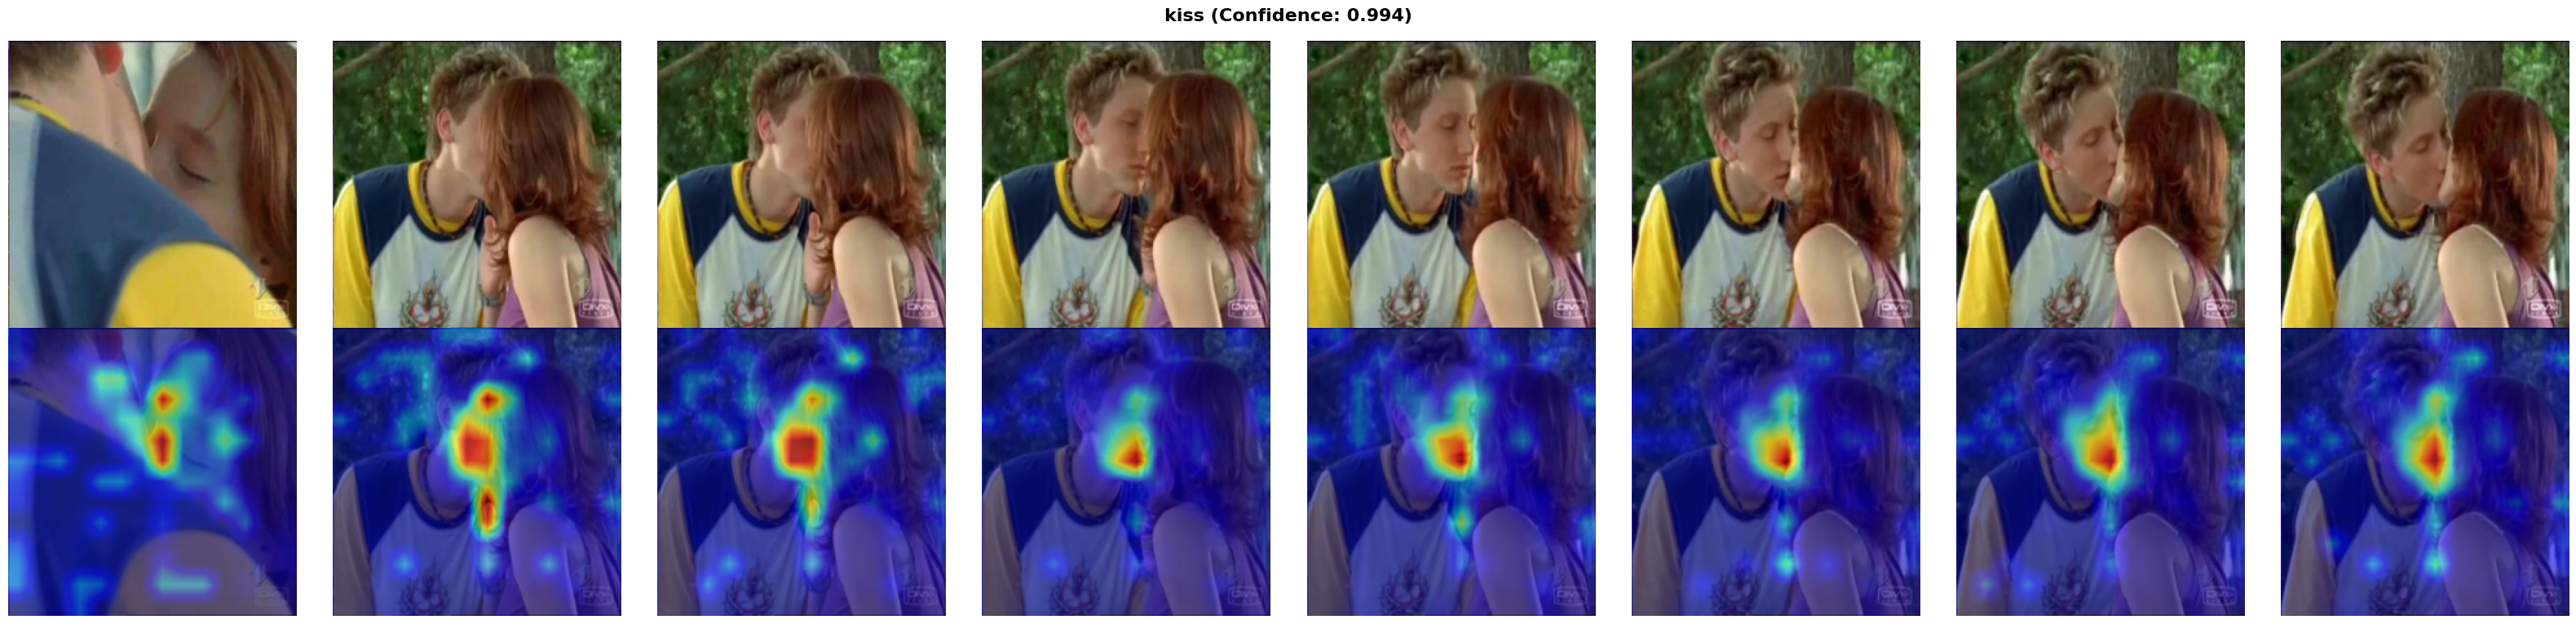

In [66]:
# TIMESFORMER ATTENTION VISUALIZATION
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from safetensors.torch import load_file
warnings.filterwarnings('ignore')

# UPDATE THESE PATHS
MODEL_PATH = "/content/drive/MyDrive/final_scripts/baseline_best/timesformer_model/model.safetensors"  # Update this path
DATA_DIR = "/content/drive/MyDrive/AML/HMDB_simp"   # Update this path

class TimeSformerAttentionVisualizer:
    def __init__(self, model, device='cuda'):
        self.model = model.to(device)
        self.device = device
        self.model.eval()
        self.attention_maps = []
        self.hooks = []

    def register_hooks(self):
        def hook_fn(module, input, output):
            if isinstance(output, tuple) and len(output) > 1:
                attention_weights = output[1]
                if attention_weights is not None:
                    self.attention_maps.append(attention_weights.detach().cpu())
            elif hasattr(output, 'shape') and len(output.shape) == 4:
                self.attention_maps.append(output.detach().cpu())

        for name, module in self.model.named_modules():
            if ('attention' in name.lower() or 'attn' in name.lower()) and hasattr(module, 'forward'):
                hook = module.register_forward_hook(hook_fn)
                self.hooks.append(hook)

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

    def get_cls_attention(self, video_tensor):
        self.attention_maps = []
        self.register_hooks()

        with torch.no_grad():
            video_tensor = video_tensor.to(self.device)

            # Use the working tensor format: (batch, frames, channels, height, width)
            reshaped_tensor = video_tensor.permute(0, 2, 1, 3, 4)
            outputs = self.model(pixel_values=reshaped_tensor, output_attentions=True)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            attentions = outputs.attentions if hasattr(outputs, 'attentions') else None
            prediction = torch.softmax(logits, dim=1)

        self.remove_hooks()

        if attentions is not None and len(attentions) > 0:
            attention = attentions[-1]
        elif self.attention_maps:
            attention = self.attention_maps[-1]
        else:
            return None, prediction

        cls_attention = attention[0, :, 0, :].mean(dim=0)
        cls_attention = cls_attention[1:]  # Remove CLS token

        return cls_attention, prediction

    def get_temporal_attention_maps(self, video_tensor):
        """Extract proper temporal attention maps from video sequence"""

        with torch.no_grad():
            video_tensor = video_tensor.to(self.device)
            # Use the working tensor format: (batch, frames, channels, height, width)
            reshaped_tensor = video_tensor.permute(0, 2, 1, 3, 4)  # (B, T, C, H, W)
            outputs = self.model(pixel_values=reshaped_tensor, output_attentions=True)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            attentions = outputs.attentions if hasattr(outputs, 'attentions') else None
            prediction = torch.softmax(logits, dim=1)

        if attentions is None or len(attentions) == 0:
            return None, prediction, []

        # Get the last attention layer
        last_attention = attentions[-1]  # Shape: (B, num_heads, num_tokens, num_tokens)

        # Extract CLS token attention to patch tokens
        cls_attention = last_attention[:, :, 0, 1:]  # Shape: [B, num_heads, T × num_patches]

        # Average across attention heads
        cls_attention = cls_attention.mean(dim=1)  # Shape: [B, T × num_patches]

        # Normalize attention weights
        cls_attention = cls_attention / (cls_attention.max(dim=1, keepdim=True)[0] + 1e-8)

        # Calculate dimensions
        num_frames = video_tensor.shape[2]  # Should be 8
        patch_size = 16  # TimeSformer patch size
        img_size = video_tensor.shape[-1]  # Should be 224
        patches_per_dim = img_size // patch_size  # Should be 14
        num_patches_per_frame = patches_per_dim * patches_per_dim  # Should be 196

        # Reshape to separate temporal and spatial dimensions
        # Shape: [B, T, num_patches_per_frame] -> [B, T, patch_h, patch_w]
        cls_attention_reshaped = cls_attention.reshape(-1, num_frames, patches_per_dim, patches_per_dim)

        # Extract individual frame attention maps
        frame_attentions = []
        for t in range(min(8, num_frames)):  # Get up to 5 frames
            frame_attention = cls_attention_reshaped[0, t]  # Shape: [patch_h, patch_w]
            frame_attentions.append(frame_attention)

        return cls_attention, prediction, frame_attentions

    def create_temporal_visualization(self, video_tensor, video_frames, class_names, num_display_frames=8):
        """Create visualization using proper temporal attention extraction"""

        # Get temporal attention maps
        cls_attention, prediction, frame_attentions = self.get_temporal_attention_maps(video_tensor)

        if not frame_attentions:
            return None, None

        # Get prediction info
        top_pred = torch.argmax(prediction, dim=1).item()
        confidence = prediction[0, top_pred].item()

        # Use the number of frames we actually have attention for
        actual_frames = min(num_display_frames, len(video_frames), len(frame_attentions))

        # Select corresponding video frames
        if len(video_frames) >= actual_frames:
            # Take evenly spaced frames to match attention frames
            indices = np.linspace(0, len(video_frames)-1, actual_frames, dtype=int)
            selected_frames = [video_frames[i] for i in indices]
        else:
            selected_frames = video_frames[:actual_frames]

        fig, axes = plt.subplots(2, actual_frames, figsize=(4*actual_frames, 8))

        if actual_frames == 1:
            axes = axes.reshape(2, 1)

        for i in range(actual_frames):
            # Process frame for display
            frame = selected_frames[i]
            if isinstance(frame, torch.Tensor):
                frame_display = frame.permute(1, 2, 0).cpu().numpy()
                # Denormalize
                if frame_display.min() < 0:
                    frame_display = frame_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                frame_display = np.clip(frame_display, 0, 1)
                frame_display = (frame_display * 255).astype(np.uint8)
            else:
                frame_display = np.array(frame)

            # Get attention map for this frame
            attention_map = frame_attentions[i].cpu().numpy()
            # Normalize attention map
            attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-8)
            # Upsample to image size
            attention_upsampled = cv2.resize(attention_map, (frame_display.shape[1], frame_display.shape[0]))

            # Row 1: Original frame
            axes[0, i].imshow(frame_display)
            axes[0, i].axis('off')

            # Row 2: Frame with attention overlay
            axes[1, i].imshow(frame_display)
            overlay = axes[1, i].imshow(attention_upsampled, cmap='jet', alpha=0.6)
            axes[1, i].axis('off')

        # Add main title
        plt.suptitle(f'{class_names[top_pred]} (Confidence: {confidence:.3f})',
                    fontsize=16, fontweight='bold', y=0.95)

        # Adjust layout
        plt.tight_layout()
        plt.subplots_adjust(top=0.90)
        plt.show()

        return frame_attentions, prediction

def load_model_and_create_visualizer():
    """Load model from safetensors and create visualizer"""
    # Define class mappings
    label_index_dict = {
        'brush_hair': 0, 'cartwheel': 1, 'catch': 2, 'chew': 3, 'climb': 4,
        'climb_stairs': 5, 'draw_sword': 6, 'eat': 7, 'fencing': 8, 'flic_flac': 9,
        'golf': 10, 'handstand': 11, 'kiss': 12, 'pick': 13, 'pour': 14,
        'pullup': 15, 'pushup': 16, 'ride_bike': 17, 'shoot_bow': 18, 'shoot_gun': 19,
        'situp': 20, 'smile': 21, 'smoke': 22, 'throw': 23, 'wave': 24
    }
    index_label_dict = {v: k for k, v in label_index_dict.items()}

    # Create model
    model = TimesformerForVideoClassification.from_pretrained(
        "facebook/timesformer-base-finetuned-k400",
        label2id=label_index_dict,
        id2label=index_label_dict,
        ignore_mismatched_sizes=True
    )

    # Load weights
    state_dict = load_file(MODEL_PATH)
    model.load_state_dict(state_dict, strict=False)

    # Create visualizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    visualizer = TimeSformerAttentionVisualizer(model, device=device)

    return visualizer

def load_sample_video():
    """Load a random video from the dataset"""
    import random

    # Get all available videos
    all_videos = []
    actions = sorted(os.listdir(DATA_DIR))

    for action in actions:
        action_path = os.path.join(DATA_DIR, action)
        if os.path.isdir(action_path):
            videos = os.listdir(action_path)
            for video in videos:
                video_path = os.path.join(action_path, video)
                if os.path.isdir(video_path):
                    frames = sorted([f for f in os.listdir(video_path)
                                   if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
                    if len(frames) >= 8:
                        all_videos.append((video_path, action, frames))

    if not all_videos:
        return None, None, None

    # Select a random video
    video_path, action, frames = random.choice(all_videos)
    return video_path, action, frames

def create_video_tensor(video_path, frames, clip_size=8):
    """Create video tensor from frames"""
    # Sample more frames for better visualization
    if len(frames) > clip_size:
        step = len(frames) / clip_size
        indices = [int(i * step) for i in range(clip_size)]
        sampled_frames = [frames[min(idx, len(frames)-1)] for idx in indices]
    else:
        sampled_frames = frames[:clip_size]
        while len(sampled_frames) < clip_size:
            sampled_frames.append(sampled_frames[-1])

    # Load and transform frames
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    processed_frames = []

    for frame_name in sampled_frames:
        frame_path = os.path.join(video_path, frame_name)
        try:
            img = Image.open(frame_path).convert('RGB')
            transformed = transform(img)
            processed_frames.append(transformed)
        except:
            # Create black frame as fallback
            img = Image.fromarray(np.zeros((224, 224, 3), dtype=np.uint8))
            processed_frames.append(transform(img))

    # Create video tensor: (batch, channels, frames, height, width)
    stacked_frames = torch.stack(processed_frames)  # (8, 3, 224, 224)
    video_tensor = stacked_frames.unsqueeze(0)  # (1, 8, 3, 224, 224)
    video_tensor = video_tensor.permute(0, 2, 1, 3, 4)  # (1, 3, 8, 224, 224)

    return video_tensor, processed_frames

def run_attention_visualization():
    """Main function to run attention visualization"""

    # Class names
    class_names = [
        'brush_hair', 'cartwheel', 'catch', 'chew', 'climb',
        'climb_stairs', 'draw_sword', 'eat', 'fencing', 'flic_flac',
        'golf', 'handstand', 'kiss', 'pick', 'pour',
        'pullup', 'pushup', 'ride_bike', 'shoot_bow', 'shoot_gun',
        'situp', 'smile', 'smoke', 'throw', 'wave'
    ]

    # Check if files exist
    if not os.path.exists(MODEL_PATH) or not os.path.exists(DATA_DIR):
        print("Error: Please update MODEL_PATH and DATA_DIR at the top of this code")
        return

    try:
        # Load model and data
        visualizer = load_model_and_create_visualizer()
        video_path, action, frames = load_sample_video()

        if video_path is None:
            print("Error: No suitable video found")
            return

        # Create tensor and process frames
        video_tensor, video_frames = create_video_tensor(video_path, frames, clip_size=8)

        # Create temporal attention visualization
        frame_attentions, prediction = visualizer.create_temporal_visualization(
            video_tensor, video_frames, class_names, num_display_frames=8
        )

    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()


# RUN THE VISUALIZATION
run_attention_visualization()

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import warnings